In [29]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


/kaggle/input/creditcardfraud/creditcard.csv


## Reading Data

In [2]:
path="/kaggle/input/creditcardfraud/creditcard.csv"
data=pd.read_csv(path)

## Dataset Information

In [3]:
usage=data.memory_usage(index=False)
TO_MB=(1024)**2
print(f"All Columns Has Same Size Of {round(usage[0]/TO_MB)} MB \n The Sum Of Total Memory Usage Is {round(sum(usage)/TO_MB)} MB")

All Columns Has Same Size Of 2 MB 
 The Sum Of Total Memory Usage Is 67 MB


In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
data[["Time","Amount","Class"]].describe().T.style.background_gradient(subset="mean",axis=0,cmap="bwr",vmin=.5,vmax=1,low=.4,high=.8)\
                        .background_gradient(subset=["std","50%"],axis=0,cmap="bwr")\
                        .background_gradient(subset="max",axis=0,cmap="Blues_r",low=.2,high=.9)

,count,mean,std,min,25%,50%,75%,max
Time,284807.000000,94813.859575,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
Amount,284807.000000,88.349619,250.120109,0.000000,5.600000,22.000000,77.165000,25691.160000
Class,284807.000000,0.001727,0.041527,0.000000,0.000000,0.000000,0.000000,1.000000


492 Of Frauds
284315 No Frauds


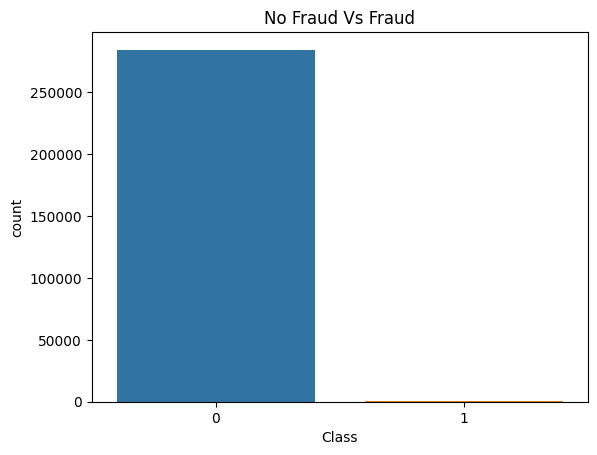

In [10]:
fraud=len(data[data["Class"]==1])
no_fraud=len(data[data["Class"]==0])
print(f"{fraud} Of Frauds")
print(f"{no_fraud} No Frauds")
sns.countplot(data=data,x="Class")
plt.title("No Fraud Vs Fraud")
plt.show()

## EDA

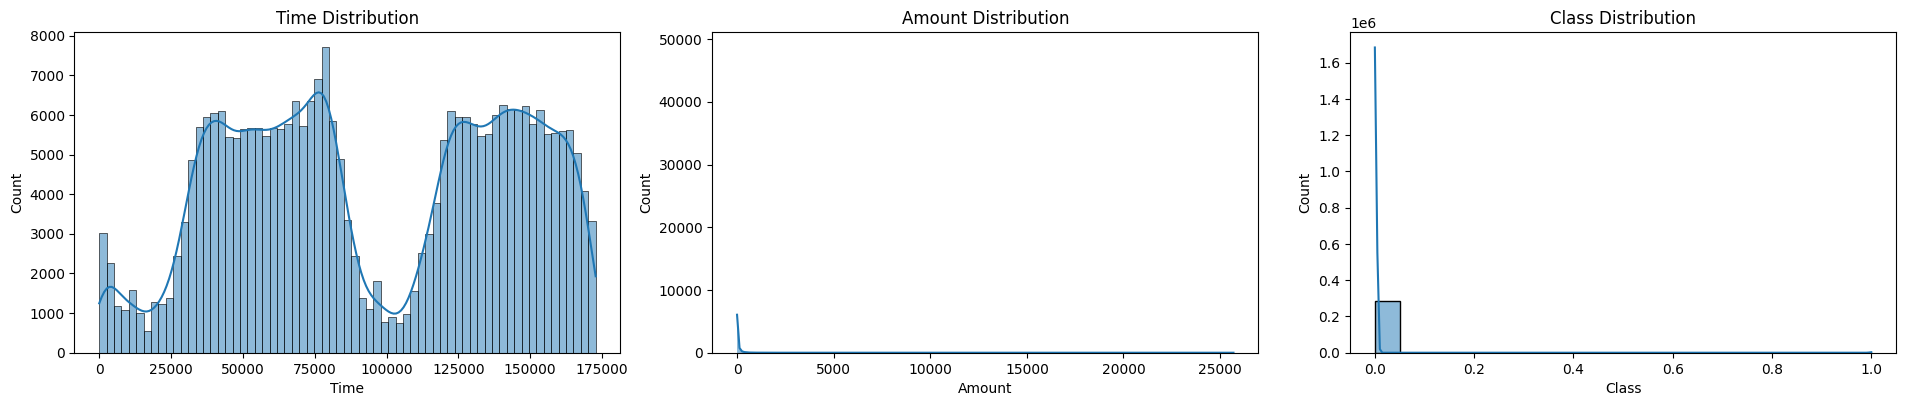

In [8]:
fig,axs=plt.subplots(1,3,figsize=(19,4))
sns.histplot(data["Time"],ax=axs[0],kde=True)
axs[0].set_title("Time Distribution")

sns.histplot(data["Amount"],ax=axs[1],kde=True)
axs[1].set_title("Amount Distribution")

sns.histplot(data["Class"],ax=axs[2],kde=True)
axs[2].set_title("Class Distribution")
plt.tight_layout(pad=.5)
plt.show()

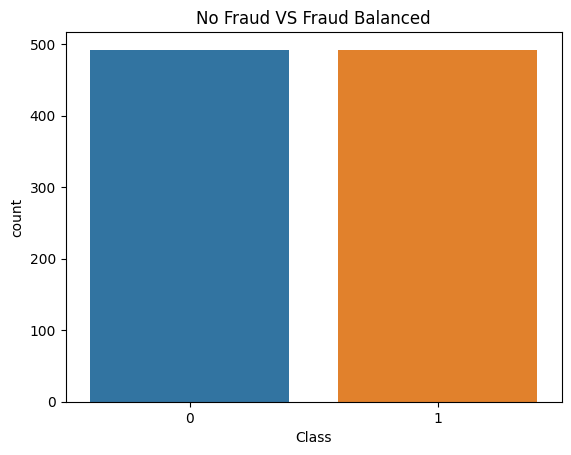

In [32]:
# Take 492 row from the no fraud class Because The dataset is unbalanced
fraud_df=data.loc[data["Class"]==0][:492]
no_fraud_df=data.loc[data["Class"]==1]
new_norm_dist_df=pd.concat([fraud_df,no_fraud_df])
sns.countplot(data=new_norm_dist_df,x="Class")
plt.title("No Fraud VS Fraud Balanced")
plt.show()

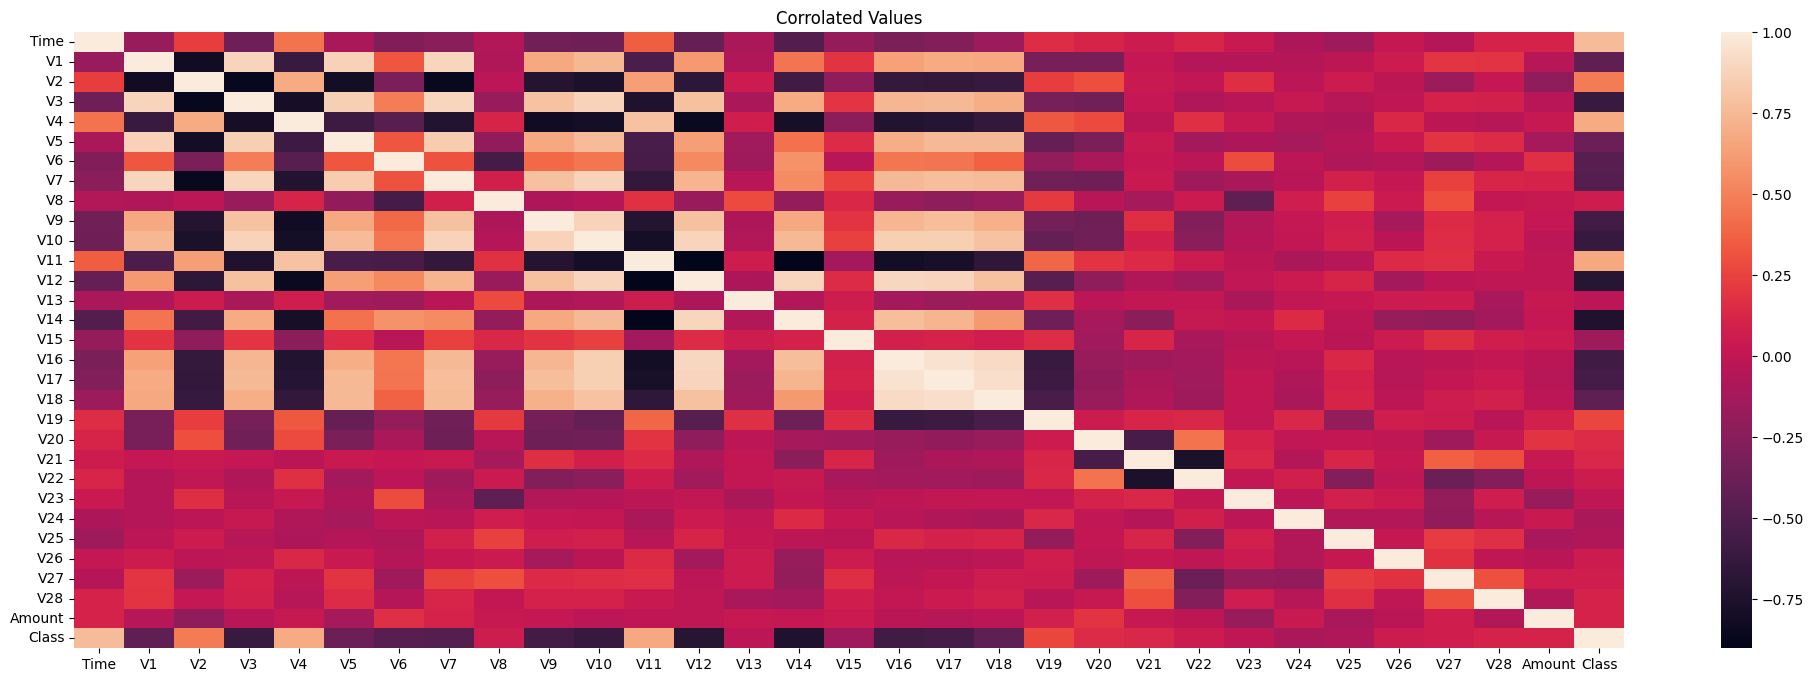

In [60]:
sns.color_palette(palette="husl",n_colors=10)
plt.figure(figsize=(25,8))
corr_data=new_norm_dist_df.corr()
sns.heatmap(data=corr_data)
plt.title("Corrolated Values")
plt.show()

<ul>
    <li>V3,V5,V17,V18 Are Negatively Corrolated</li>
    <li>V2,V4,V11,V19 Are Positively Corrolated</li>
</ul>

<h3> Detecting Outliers </h3>

<AxesSubplot: xlabel='Class', ylabel='V19'>

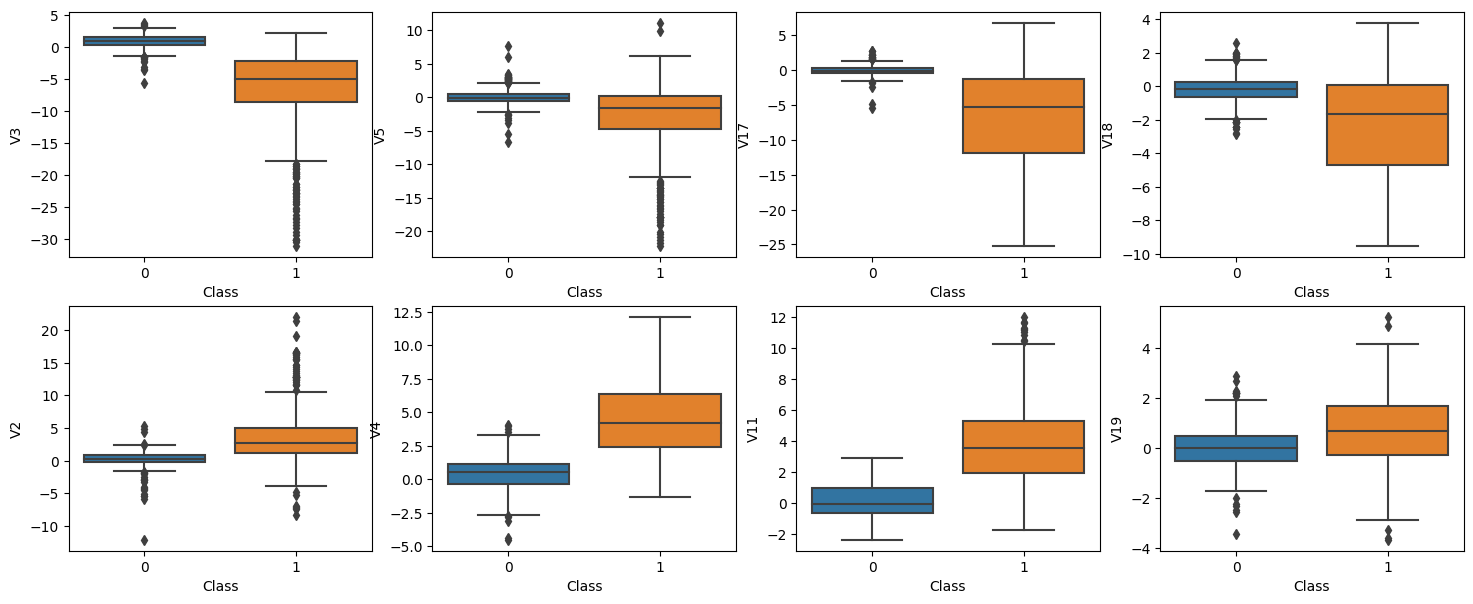

In [69]:
negative_corr_cols=["V3","V5","V17","V18"]
positive_corr_cols=["V2","V4","V11","V19"]

fig,axs=plt.subplots(nrows=2,ncols=4,figsize=(18,7))
sns.boxplot(ax=axs[0,0],data=new_norm_dist_df,x="Class",y=negative_corr_cols[0])

sns.boxplot(ax=axs[0,1],data=new_norm_dist_df,x="Class",y=negative_corr_cols[1])

sns.boxplot(ax=axs[0,2],data=new_norm_dist_df,x="Class",y=negative_corr_cols[2])

sns.boxplot(ax=axs[0,3],data=new_norm_dist_df,x="Class",y=negative_corr_cols[3])

sns.boxplot(ax=axs[1,0],data=new_norm_dist_df,x="Class",y=positive_corr_cols[0])

sns.boxplot(ax=axs[1,1],data=new_norm_dist_df,x="Class",y=positive_corr_cols[1])

sns.boxplot(ax=axs[1,2],data=new_norm_dist_df,x="Class",y=positive_corr_cols[2])

sns.boxplot(ax=axs[1,3],data=new_norm_dist_df,x="Class",y=positive_corr_cols[3])